# 메타 프롬프트 생성 에이전트

사용자로 부터 요구사항을 수집하고, 이를 바탕으로 프롬프트를 작성합니다.

- 참고: https://wikidocs.net/267817


In [ ]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 상태 정의

In [43]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

## 사용자 요구사항 수집 노드

In [ ]:
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI


class PromptInstructions(BaseModel):
    """프롬프트하는 방법에 대한 지침"""

    objective: Annotated[str, Field(..., description="프롬프트의 목표")]
    variables: Annotated[
        list[str], Field(..., description="프롬프트 템플릿에 전달될 변수 목록")
    ]
    constraints: Annotated[
        list[str], Field(..., description="출력에서 피해야 할 제약 조건 목록")
    ]
    requirements: Annotated[
        list[str], Field(..., description="출력이 반드시 따라야 할 요구사항 목록")
    ]


def uses_requirements_node(state: State):
    system_prompt = """당신의 임무는 사용자로부터 어떤 유형의 프롬프트 템플릿을 생성하고자 하는지 정보를 수집하는 것입니다.

사용자로부터 다음 정보를 수집해야 합니다:

- 프롬프트의 목적
- 프롬프트 템플릿에 전달될 변수
- 출력이 해서는 안 되는 사항에 대한 제약 조건
- 출력이 반드시 준수해야 하는 요구사항

이 정보를 파악할 수 없다면 명확히 설명해 달라고 요청하세요! 무턱대고 추측하지 마십시오.

사용자로 부터 모든 정보를 수집했다고 판단되면, 도구를 호출하십시오.

[중요] 대화는 한국어로 진행하지만, 생성된 프롬프트는 영어로 작성되어야 합니다."""

    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0).bind_tools(
        [PromptInstructions]
    )

    response = llm.invoke([("system", system_prompt)] + state["messages"])

    return {"messages": [response]}


## 프롬프트 생성 노드

참고: [OpenAI 메타 프롬프트 엔지니어링 가이드](https://platform.openai.com/docs/guides/prompt-generation?context=text-out)

In [45]:
# 프롬프트를 생성하는 메타 프롬프트 정의
META_PROMPT = """Given a task description or existing prompt, produce a detailed system prompt to guide a language model in completing the task effectively.

# Guidelines

- Understand the Task: Grasp the main objective, goals, requirements, constraints, and expected output.
- Minimal Changes: If an existing prompt is provided, improve it only if it's simple. For complex prompts, enhance clarity and add missing elements without altering the original structure.
- Reasoning Before Conclusions**: Encourage reasoning steps before any conclusions are reached. ATTENTION! If the user provides examples where the reasoning happens afterward, REVERSE the order! NEVER START EXAMPLES WITH CONCLUSIONS!
    - Reasoning Order: Call out reasoning portions of the prompt and conclusion parts (specific fields by name). For each, determine the ORDER in which this is done, and whether it needs to be reversed.
    - Conclusion, classifications, or results should ALWAYS appear last.
- Examples: Include high-quality examples if helpful, using placeholders [in brackets] for complex elements.
   - What kinds of examples may need to be included, how many, and whether they are complex enough to benefit from placeholders.
- Clarity and Conciseness: Use clear, specific language. Avoid unnecessary instructions or bland statements.
- Formatting: Use markdown features for readability. DO NOT USE ``` CODE BLOCKS UNLESS SPECIFICALLY REQUESTED.
- Preserve User Content: If the input task or prompt includes extensive guidelines or examples, preserve them entirely, or as closely as possible. If they are vague, consider breaking down into sub-steps. Keep any details, guidelines, examples, variables, or placeholders provided by the user.
- Constants: DO include constants in the prompt, as they are not susceptible to prompt injection. Such as guides, rubrics, and examples.
- Output Format: Explicitly the most appropriate output format, in detail. This should include length and syntax (e.g. short sentence, paragraph, JSON, etc.)
    - For tasks outputting well-defined or structured data (classification, JSON, etc.) bias toward outputting a JSON.
    - JSON should never be wrapped in code blocks (```) unless explicitly requested.

The final prompt you output should adhere to the following structure below. Do not include any additional commentary, only output the completed system prompt. SPECIFICALLY, do not include any additional messages at the start or end of the prompt. (e.g. no "---")

[Concise instruction describing the task - this should be the first line in the prompt, no section header]

[Additional details as needed.]

[Optional sections with headings or bullet points for detailed steps.]

# Steps [optional]

[optional: a detailed breakdown of the steps necessary to accomplish the task]

# Output Format

[Specifically call out how the output should be formatted, be it response length, structure e.g. JSON, markdown, etc]

[User given variables should be wrapped in {{brackets}}]

<Question>
{{question}}
</Question>

<Answer>
{{answer}}
</Answer>

# Examples [optional]

[Optional: 1-3 well-defined examples with placeholders if necessary. Clearly mark where examples start and end, and what the input and output are. User placeholders as necessary.]
[If the examples are shorter than what a realistic example is expected to be, make a reference with () explaining how real examples should be longer / shorter / different. AND USE PLACEHOLDERS! ]

# Notes [optional]

[optional: edge cases, details, and an area to call or repeat out specific important considerations]

# Based on the following requirements, write a good prompt template:

{reqs}
"""

In [51]:
from langchain_core.messages import AIMessage, ToolMessage


def prompt_generation_node(state: State):
    messages = state["messages"]
    new_messages: list = []
    tool_call_args = None
    for msg in messages:
        if isinstance(msg, AIMessage) and msg.tool_calls:
            tool_call_args = msg.tool_calls[0]["args"]
        elif isinstance(msg, ToolMessage):
            continue
        elif tool_call_args is not None:
            new_messages.append(msg)

    system_prompt = META_PROMPT.format(reqs=tool_call_args)

    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0.7)
    response = llm.invoke([("system", system_prompt)] + new_messages)
    return {"messages": [response]}

## 그래프 정의

In [57]:
from typing import Literal
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver


def tools_condition(state: State) -> Literal["tools", "__end__"]:
    last_message = state["messages"][-1]

    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"
    else:
        return "__end__"


builder = StateGraph(State)
builder.add_node(uses_requirements_node)
builder.add_node(prompt_generation_node)

builder.add_conditional_edges(
    uses_requirements_node.__name__,
    tools_condition,
    {
        "tools": prompt_generation_node.__name__,  # 도구 호출이 발생했다면, 프롬프트 생성 노드로 이동
        "__end__": END,  # 도구 호출이 발생하지 않았다면, 종료
    },
)
builder.set_entry_point(uses_requirements_node.__name__)

memory = InMemorySaver()
graph = builder.compile(checkpointer=memory)

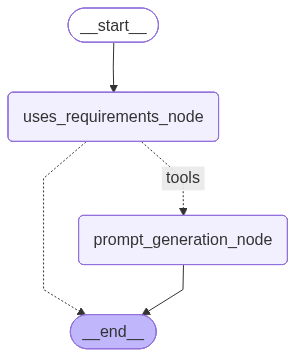

In [48]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [58]:
from random import random
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=20,
    configurable={"thread_id": str(random())},
)

for event in graph.stream(
    {"messages": [("user", "RAG 프롬프트를 생성해주세요.")]},
    stream_mode="values",
    config=config,
):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

RAG 프롬프트를 생성해주세요.
================================== Ai Message ==================================

RAG 프롬프트를 생성하기 위해 몇 가지 정보를 더 여쭤봐도 될까요?

1. 프롬프트의 목적이 무엇인가요? (예: 문서 요약, 질문 답변, 정보 검색 등)
2. 프롬프트 템플릿에 어떤 변수를 포함시키고 싶으신가요? (예: 사용자 질문, 문서 내용, 검색 결과 등)
3. 출력에서 피해야 할 제약 조건이 있나요? (예: 부적절한 내용, 과도한 길이, 특정 단어 사용 금지 등)
4. 출력이 반드시 준수해야 하는 요구사항이 있나요? (예: 간결한 답변, 특정 형식, 전문 용어 사용 등)

이 정보를 알려주시면 적합한 RAG 프롬프트 템플릿을 만들어 드리겠습니다.


In [63]:
config = RunnableConfig(
    recursion_limit=20,
    configurable={"thread_id": str(random())},
)

while True:
    user_input: str = ""
    try:
        user_input = input("User (q/Q to quit): ")
    except:
        pass

    if user_input.lower() == "q":
        break

    for event in graph.stream(
        {"messages": [("user", user_input)]},
        stream_mode="values",
        config=config,
    ):
        if "messages" in event:
            event["messages"][-1].pretty_print()


================================ Human Message =================================

RAG 프롬프트를 생성해주세요.
================================== Ai Message ==================================

RAG 프롬프트를 생성하기 위해 몇 가지 정보를 더 여쭤봐야 합니다.

1. 프롬프트의 목적이 무엇인가요? (예: 문서 요약, 질문 답변, 정보 검색 등)
2. 프롬프트 템플릿에 어떤 변수를 포함시키고 싶으신가요? (예: 사용자 질문, 문서 내용, 키워드 등)
3. 출력에서 피해야 할 제약 조건이 있나요? (예: 부적절한 내용, 과도한 길이, 특정 단어 사용 금지 등)
4. 출력이 반드시 준수해야 하는 요구사항이 있나요? (예: 간결함, 전문성, 특정 형식 준수 등)

이 정보를 알려주시면 적절한 RAG 프롬프트 템플릿을 만들어 드리겠습니다.
================================ Human Message =================================

정보 검색, 모든 변수 포함, 제약 조건 없음, 전문성
================================== Ai Message ==================================
Tool Calls:
  PromptInstructions (call_niqmziWvGWpRnfqjbvtJJfpA)
 Call ID: call_niqmziWvGWpRnfqjbvtJJfpA
  Args:
    objective: Information retrieval
    variables: ['user question', 'document content', 'keywords']
    constraints: []
    requirements: ['professionalism']
================================== Ai Messag